# Sampling rate test


**** using the conda pyds create at 2025-02-08 ****

Initializing controller...
Running sampling rate test for 15 seconds...
Move the controller around to ensure sensor data changes
Current rates - State: 245.2 Hz, Accel: 245.2 Hz
Closing controller connection...

===== DualSense Controller Sampling Rate Results =====
Test Duration: 15 seconds

State Updates:
  - Samples: 3574
  - Rate: 237.00 Hz

Accelerometer Updates (unique values only):
  - Samples: 3666
  - Rate: 243.10 Hz

Gyroscope Updates (unique values only):
  - Samples: 3666
  - Rate: 243.10 Hz

Theoretical maximum sample rate: 701.27 Hz


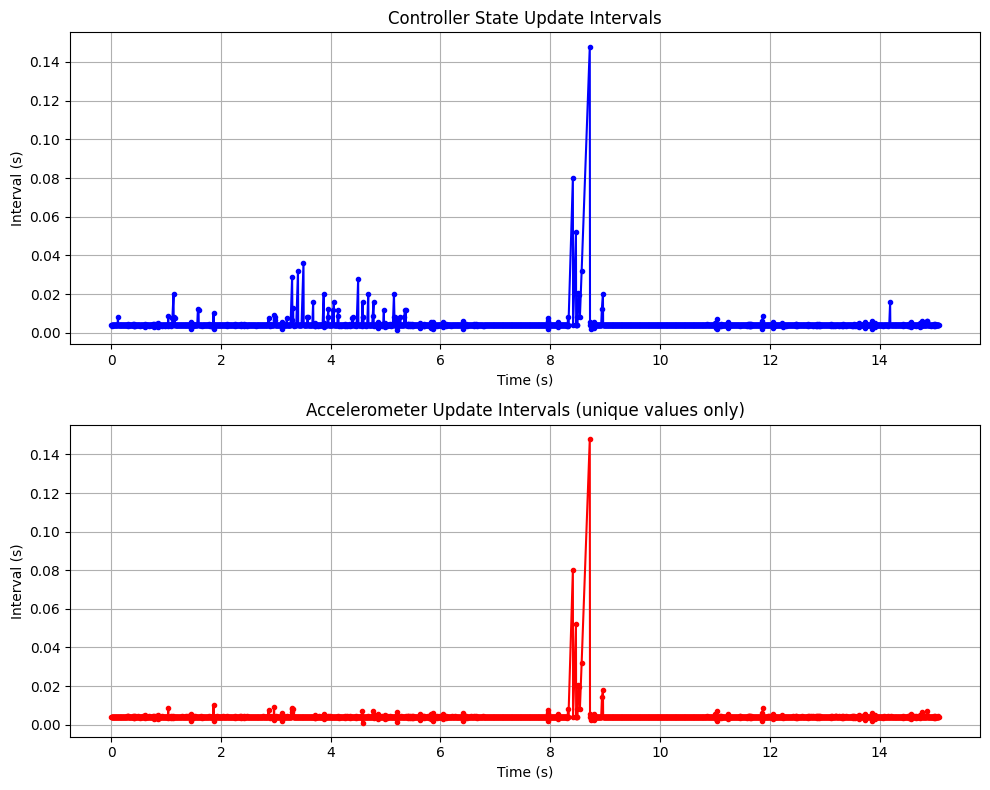

In [1]:
# HIDAPI rate test
import pydualsense
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import deque

# Class to test sampling rates
class SamplingRateTester:
    def __init__(self, test_duration=10):
        self.test_duration = test_duration
        self.controller = pydualsense.pydualsense()
        
        # Sampling data storage
        self.state_timestamps = []
        self.accel_timestamps = []
        self.gyro_timestamps = []
        
        # For detecting real data changes vs repeated values
        self.last_accel = None
        self.last_gyro = None
        
        # For real-time rate calculation
        self.accel_times = deque(maxlen=100)
        self.state_times = deque(maxlen=100)
    
    def on_state_update(self, *args): # using left joystick to trigger state update
        """Called when controller state is updated"""
        self.state_timestamps.append(time.time())
        
        # Calculate real-time rate
        if len(self.state_timestamps) > 1:
            delta = self.state_timestamps[-1] - self.state_timestamps[-2]
            self.state_times.append(delta)
    
    def on_accel_update(self, x, y, z):
        """Called when accelerometer data changes"""
        current_accel = (x, y, z)
        
        # Check if values actually changed (to detect real sampling rate)
        if self.last_accel != current_accel:
            self.accel_timestamps.append(time.time())
            self.last_accel = current_accel
            
            # Calculate real-time rate
            if len(self.accel_timestamps) > 1:
                delta = self.accel_timestamps[-1] - self.accel_timestamps[-2]
                self.accel_times.append(delta)
    
    def on_gyro_update(self, pitch, yaw, roll):
        """Called when gyroscope data changes"""
        current_gyro = (pitch, yaw, roll)
        
        # Check if values actually changed
        if self.last_gyro != current_gyro:
            self.gyro_timestamps.append(time.time())
            self.last_gyro = current_gyro
    
    def register_callbacks(self):
        """Register callbacks for controller events"""
        # Register callbacks by direct assignment (not append)
        self.controller.left_joystick_changed = self.on_state_update # using left joystick to trigger state update
        self.controller.accelerometer_changed = self.on_accel_update
        self.controller.gyro_changed = self.on_gyro_update
    
    def run_test(self):
        """Run the sampling rate test"""
        print("Initializing controller...")
        self.controller.init()
        
        # Register callbacks after init
        self.register_callbacks()
        
        print(f"Running sampling rate test for {self.test_duration} seconds...")
        print("Move the controller around to ensure sensor data changes")
        
        start_time = time.time()
        
        try:
            while time.time() - start_time < self.test_duration:
                # Print current rates
                if len(self.state_times) > 10 and len(self.accel_times) > 10:
                    state_rate = 1.0 / np.mean(list(self.state_times))
                    accel_rate = 1.0 / np.mean(list(self.accel_times))
                    print(f"\rCurrent rates - State: {state_rate:.1f} Hz, Accel: {accel_rate:.1f} Hz", end="")
                
                time.sleep(0.1)
        
        except KeyboardInterrupt:
            print("\nTest interrupted")
        finally:
            print("\nClosing controller connection...")
            self.controller.close()
    
    def calculate_results(self):
        """Calculate and return the sampling rates"""
        results = {}
        
        # Calculate state update rate
        if len(self.state_timestamps) > 2:
            intervals = np.diff(self.state_timestamps)
            results['state_rate'] = 1.0 / np.mean(intervals)
            results['state_samples'] = len(self.state_timestamps)
        else:
            results['state_rate'] = 0
            results['state_samples'] = 0
        
        # Calculate accelerometer update rate (real changes only)
        if len(self.accel_timestamps) > 2:
            intervals = np.diff(self.accel_timestamps)
            results['accel_rate'] = 1.0 / np.mean(intervals)
            results['accel_samples'] = len(self.accel_timestamps)
        else:
            results['accel_rate'] = 0
            results['accel_samples'] = 0
        
        # Calculate gyroscope update rate (real changes only)
        if len(self.gyro_timestamps) > 2:
            intervals = np.diff(self.gyro_timestamps)
            results['gyro_rate'] = 1.0 / np.mean(intervals)
            results['gyro_samples'] = len(self.gyro_timestamps)
        else:
            results['gyro_rate'] = 0
            results['gyro_samples'] = 0
        
        return results
    
    def print_results(self):
        """Print the sampling rate test results"""
        results = self.calculate_results()
        
        print("\n===== DualSense Controller Sampling Rate Results =====")
        print(f"Test Duration: {self.test_duration} seconds")
        print(f"\nState Updates:")
        print(f"  - Samples: {results['state_samples']}")
        print(f"  - Rate: {results['state_rate']:.2f} Hz")
        
        print(f"\nAccelerometer Updates (unique values only):")
        print(f"  - Samples: {results['accel_samples']}")
        print(f"  - Rate: {results['accel_rate']:.2f} Hz")
        
        print(f"\nGyroscope Updates (unique values only):")
        print(f"  - Samples: {results['gyro_samples']}")
        print(f"  - Rate: {results['gyro_rate']:.2f} Hz")
        
        # Calculate maximum possible sample rate based on pydualsense implementation
        if len(self.state_timestamps) > 2:
            min_interval = min(np.diff(self.state_timestamps))
            print(f"\nTheoretical maximum sample rate: {1.0/min_interval:.2f} Hz")
        
        return results
        
    def plot_results(self):
        """Plot sampling intervals"""
        if len(self.state_timestamps) > 2 and len(self.accel_timestamps) > 2:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
            
            # State update intervals
            state_intervals = np.diff(self.state_timestamps)
            # Convert to numpy array first for element-wise subtraction
            relative_times = np.array(self.state_timestamps[1:]) - self.state_timestamps[0]
            ax1.plot(relative_times, state_intervals, 'b.-')
            ax1.set_title('Controller State Update Intervals')
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Interval (s)')
            ax1.grid(True)
            
            # Accelerometer update intervals
            accel_intervals = np.diff(self.accel_timestamps)
            # Same fix for accelerometer timestamps
            relative_accel_times = np.array(self.accel_timestamps[1:]) - self.accel_timestamps[0]
            ax2.plot(relative_accel_times, accel_intervals, 'r.-')
            ax2.set_title('Accelerometer Update Intervals (unique values only)')
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('Interval (s)')
            ax2.grid(True)
            
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough data points to generate plots")

# Run the test
test_duration = 15  # seconds
tester = SamplingRateTester(test_duration=test_duration)
tester.run_test()
results = tester.print_results()
tester.plot_results()